/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
12/12 [==============================] - 27s 2s/step - loss: 0.4773 - accuracy: 0.8465 - val_loss: 0.5009 - val_accuracy: 0.7850
Epoch 2/100
12/12 [==============================] - 26s 2s/step - loss: 0.1962 - accuracy: 0.9361 - val_loss: 0.4268 - val_accuracy: 0.8400
Epoch 3/100
12/12 [==============================] - 26s 2s/step - loss: 0.1597 - accuracy: 0.9524 - val_loss: 1.3143 - val_accuracy: 0.5300
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 0.1225 - accuracy: 0.9660 - val_loss: 1.6664 - val_accuracy: 0.5300
Epoch 5/100
12/12 [==============================] - 25s 2s/step - loss: 0.0926 - accuracy: 0.9742 - val_loss: 2.3644 - val_accuracy: 0.5300
Epoch 6/100
12/12 [==============================] - 25s 2s/step - loss: 0.1188 - accuracy: 0.9565 - val_loss: 3.2136 - val_accuracy: 0.5300
Epoch 7/100
12/12 [==============================] - 25s 2s/step - loss: 0.1405 - accuracy: 0.9592 - val_loss: 2.2930 - val_accuracy: 0.5300
Epoch 8/100
1

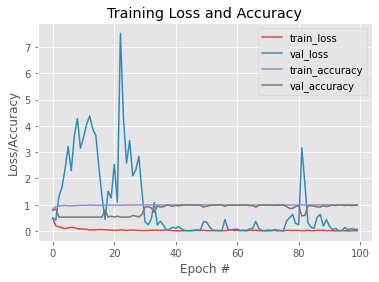

In [ ]:
#  pip install tensorflow
#  pip install scikit-learn
#  pip install matplotlib
#  pip install opencv-python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

# initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)

data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'dataset' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)

    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]  # dataset\mask\face_1162.jpg
    if label == "mask":
        label = 1
    else:
        label = 0

    labels.append([label])  # [[1], [0], [0], ...]

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2)  # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

# augmenting datset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":  # Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1

    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first",
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
              classes=2)

# compile the model
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
model.save('facemask_detection.model')

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')

[[110   1]
 [  0  89]]


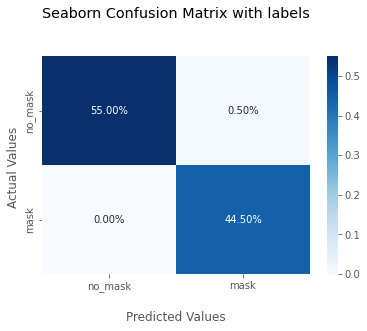

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

data = []
labels = []
img_dims = (96, 96, 3)

# load image files from the dataset
image_files = [f for f in glob.glob(r'/content/dataset' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)

    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]  # dataset\woman\face_1162.jpg
    if label == "mask":
        label = 1
    else:
        label = 0

    labels.append([label])  # [[1], [0], [0], ...]

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2)  # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

from tensorflow.keras.models import load_model

model = load_model('facemask_detection.model')

y_pred = model.predict(testX)

new_y_pred = []
for i in y_pred:
  new_y_pred.append(np.argmax(i))

new_y_test = []
for i in testY:
  new_y_test.append(np.argmax(i))

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(new_y_test, new_y_pred)

print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['no_mask','mask'])
ax.yaxis.set_ticklabels(['no_mask','mask'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(new_y_test, new_y_pred))

0.995


In [ ]:
print(trainX.shape)

(800, 96, 96, 3)


In [ ]:
print(trainY.shape)

(800, 2)


In [ ]:
print(trainX.shape)

(800, 96, 96, 3)


In [ ]:
print(testY.shape)

(200, 2)


In [ ]:
trainX.shape


(800, 96, 96, 3)